# Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from joblib import dump

In [2]:
# Set the theme for figures
sns.set_theme()
warnings.filterwarnings('ignore')

In [3]:
# load the daily rainfall time series data
daily = pd.read_parquet('data/rain_time_series.parquet')

remove january 2023 so we have only complete years

In [4]:
daily = daily.query('index < "2023-01-01" ')

# Feature creation

Create features for year, month, day of the month, and day of the year. We will use these as features to train our model on

In [5]:
def get_features(df):
    """
    Create temporal features from time series dataframe index
    """
    df['day_of_year'] = df.index.day_of_year
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day

    return df

In [6]:
daily = get_features(daily)

In [7]:
daily.head()

,rain,day_of_year,year,month,day
2006-10-01,0,274,2006,10,1
2006-10-02,0,275,2006,10,2
2006-10-03,0,276,2006,10,3
2006-10-04,0,277,2006,10,4
2006-10-05,0,278,2006,10,5


Create a monthly rainfall total dataframe too because daily rainfall prediction might be too inaccurate and unnecessary.

In [8]:
monthly = pd.DataFrame(data=daily.groupby(['year', 'month']).agg('sum')['rain'].values, index=daily.query('day == 1').index, columns=['total_rain_mm'])

In [9]:
monthly = get_features(monthly)

In [10]:
monthly.head()

,total_rain_mm,day_of_year,year,month,day
2006-10-01,22,274,2006,10,1
2006-11-01,187,305,2006,11,1
2006-12-01,78,335,2006,12,1
2007-01-01,18,1,2007,1,1
2007-02-01,32,32,2007,2,1


# Plot the time series data

Text(0.5, 1.0, 'daily rainfall')

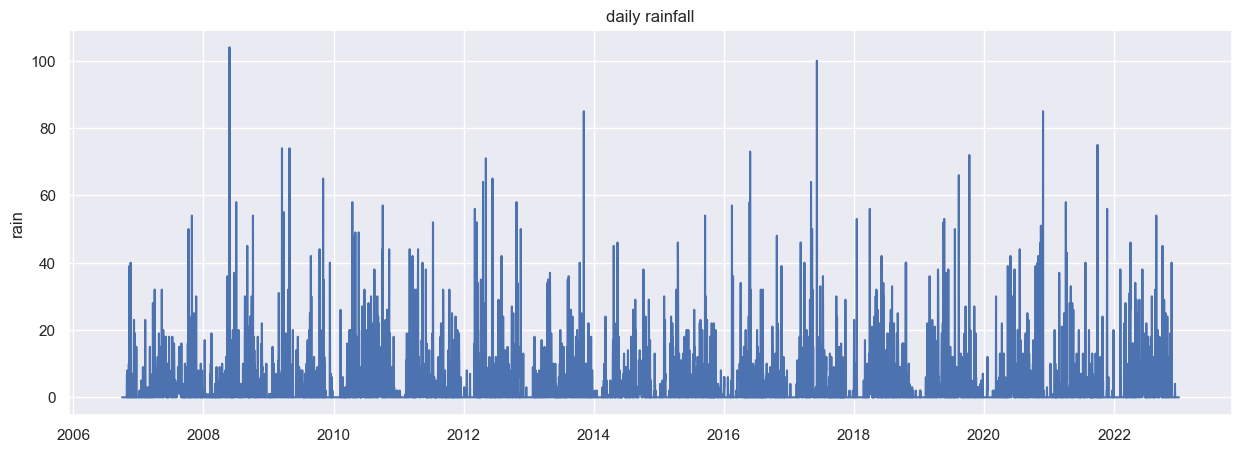

In [11]:
plt.figure(figsize=(15,5))
sns.lineplot(x=daily.index, y=daily.rain)
plt.title('daily rainfall')

Text(0.5, 1.0, 'Monthly Rainfall Totals')

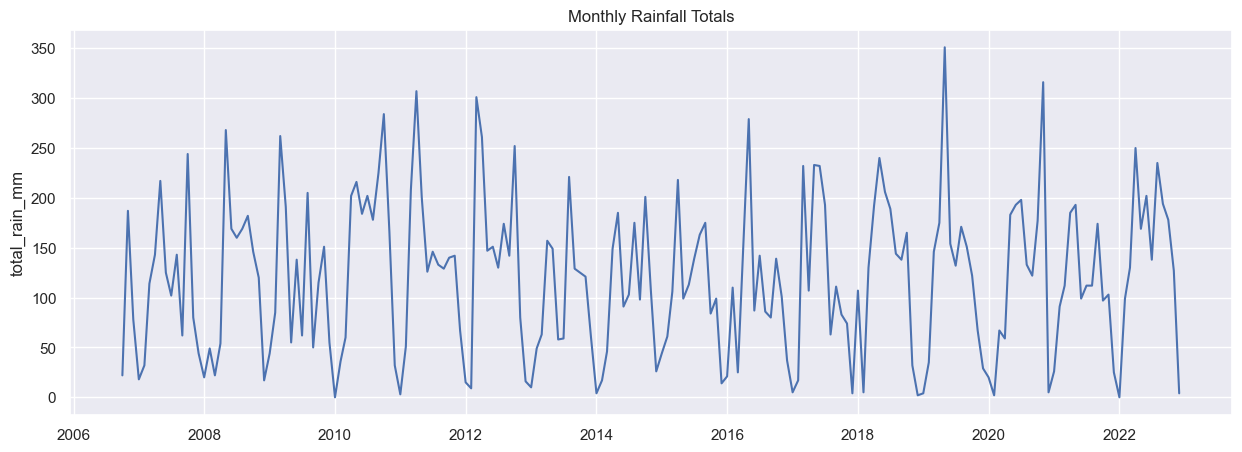

In [12]:
plt.figure(figsize=(15,5))
sns.lineplot(x=monthly.index, y=monthly.total_rain_mm)
plt.title('Monthly Rainfall Totals')

There is clearly a yearly seasonality visible in the data that I have explored elsewhere. Let's proceed with the time series model.

# Time Series Cross Fold Validation

I will perform time series cross fold validation which is different from standard cross fold validation in that the order dates needs to be preserved. I will start with 5 fold cross validation and will visualize each of the folds below. The orange points are the validation sets and the blue points are the training sets.

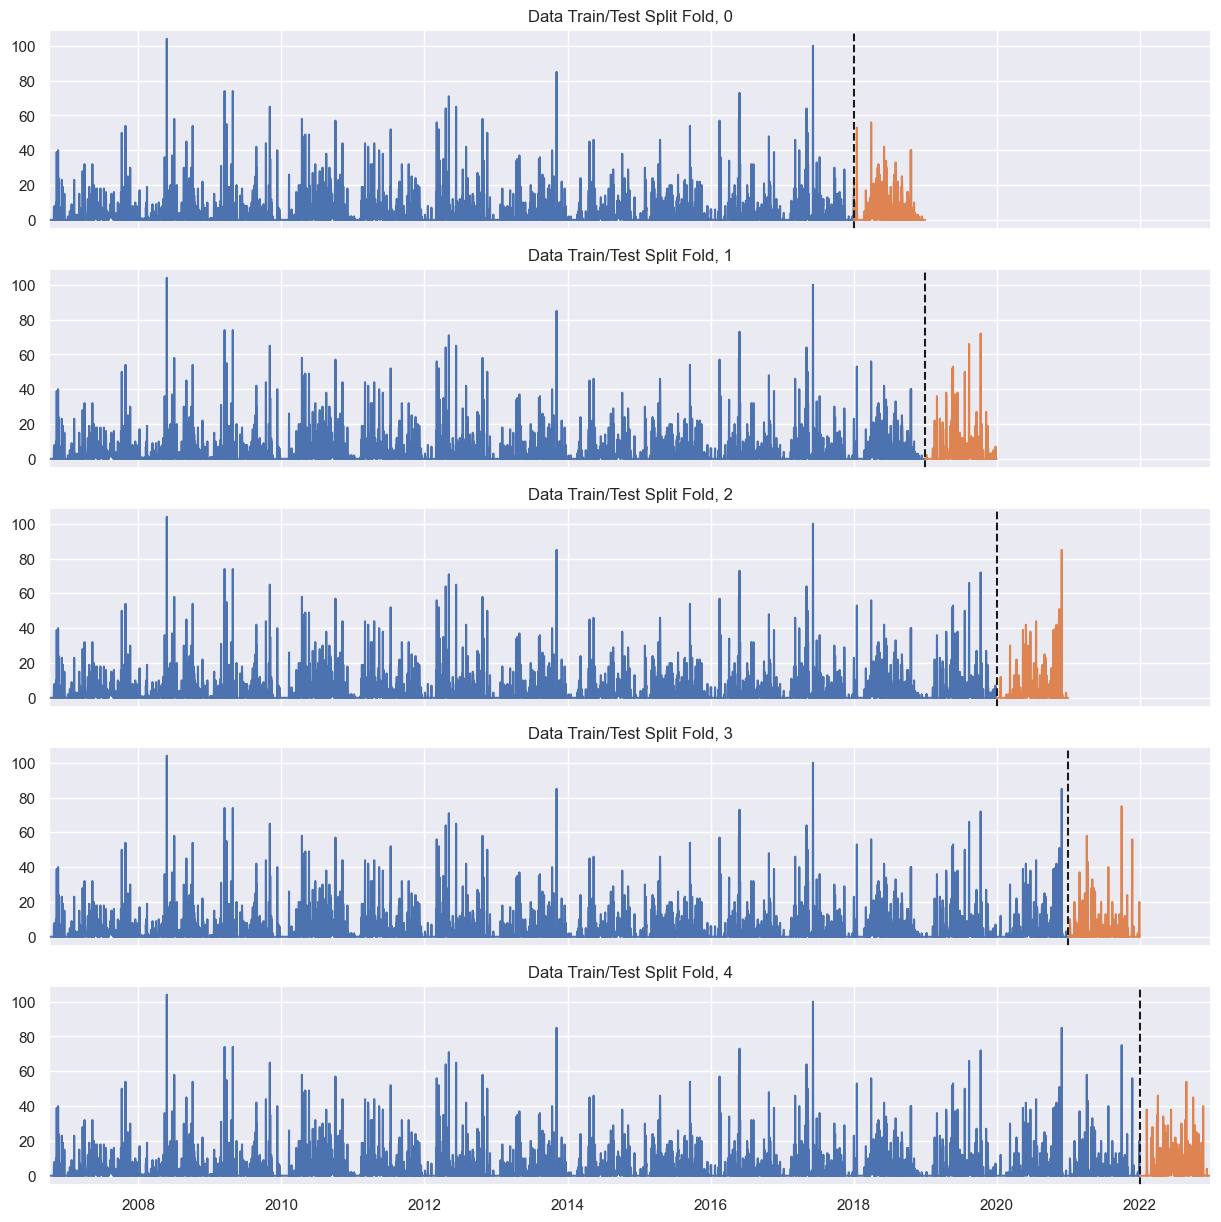

In [13]:
tss_daily = TimeSeriesSplit(n_splits=5, test_size=365)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss_daily.split(daily)):
    
    train = daily.iloc[train_idx]
    test = daily.iloc[val_idx]

    train['rain'].plot(ax=axs[fold], 
                       label='Training Set',
                       title=f'Data Train/Test Split Fold, {fold}')
    test['rain'].plot(ax=axs[fold], 
                       label='Test Set')
    axs[fold].axvline(test.index.min(), color='k', ls='--')

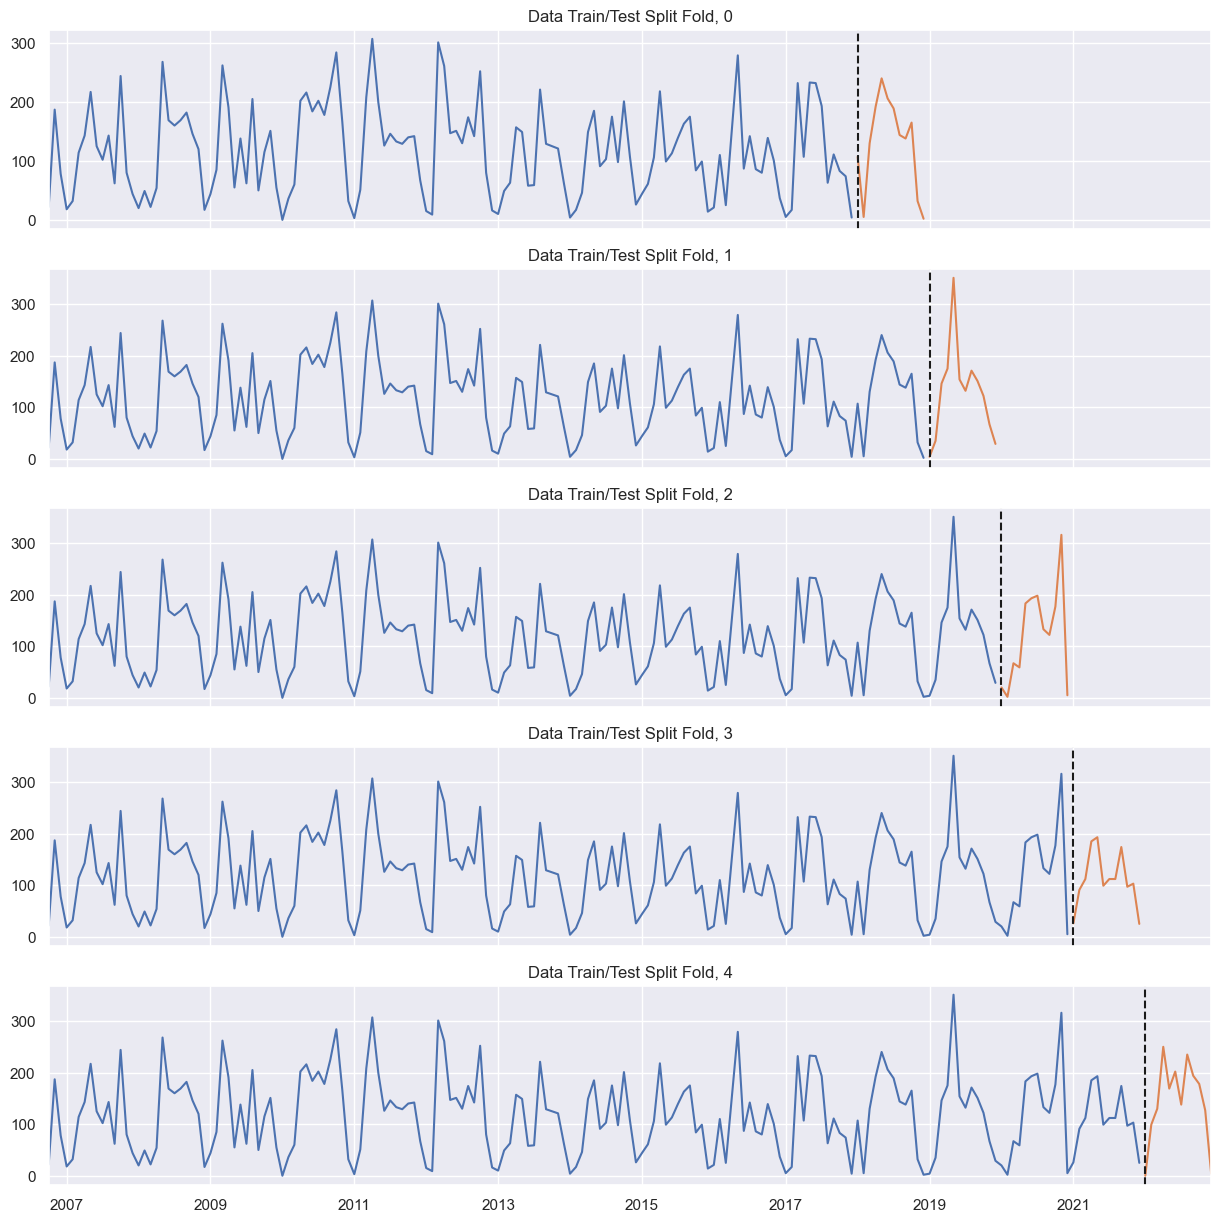

In [14]:
tss_monthly = TimeSeriesSplit(n_splits=5, test_size=12, gap=0)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss_monthly.split(monthly)):
    
    train = monthly.iloc[train_idx]
    test = monthly.iloc[val_idx]

    train['total_rain_mm'].plot(ax=axs[fold], 
                       label='Training Set',
                       title=f'Data Train/Test Split Fold, {fold}')
    test['total_rain_mm'].plot(ax=axs[fold], 
                       label='Test Set')
    axs[fold].axvline(test.index.min(), color='k', ls='--')

In [15]:
# def get_lags(df):
#     # create a dictionary for mapping lag features
#     target_map = df['total_rain_mm'].to_dict()

#     df['lag_1y'] = (df.index - pd.Timedelta('12 months')).map(target_map)
#     df['lag_2y'] = (df.index - pd.Timedelta('24 months')).map(target_map)
#     df['lag_3y'] = (df.index - pd.Timedelta('36 months')).map(target_map)
#     df['lag_4y'] = (df.index - pd.Timedelta('48 months')).map(target_map)

#     # df['lag_1d'] = (df.index - pd.Timedelta('1 days')).map(target_map)
#     # df['lag_2d'] = (df.index - pd.Timedelta('2 days')).map(target_map)
#     # df['lag_3d'] = (df.index - pd.Timedelta('3 days')).map(target_map)

#     # in order to avoid data leakage we need to calculate the mean and standard deviation window 
#     # functions on the 1 day lag data.
#     # df['mean_1w'] = df['lag_1d'].rolling(7).mean()
#     # df['mean_2d'] = df['lag_1d'].rolling(2).mean()
#     # df['mean_4d'] = df['lag_1d'].rolling(4).mean()

#     # df['std_1w'] = df['lag_1d'].rolling(7).std()
#     # df['std_2d'] = df['lag_1d'].rolling(2).std()
#     # df['std_4d'] = df['lag_1d'].rolling(4).std()

#     return df

In [16]:
daily.columns

Index(['rain', 'day_of_year', 'year', 'month', 'day'], dtype='object')

In [17]:
# tss_daily = TimeSeriesSplit(n_splits=5, test_size=365)

# FEATURES = ['day_of_year', 'year', 'month', 'day']
# TARGET = 'rain'

# models = []
# oof_preds = []
# scores = []
# fi = []

# for fold, (train_idx, test_idx) in enumerate(tss_daily.split(daily)):
#     train = daily.iloc[train_idx]
#     test = daily.iloc[test_idx]

# #     train = get_lags(train)
# #     test = get_lags(test)

#     X_train = train[FEATURES]
#     y_train = train[TARGET]

#     X_test = test[FEATURES]
#     y_test = test[TARGET]
#     eval_set = [(X_test, y_test)]

#     reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=2000)
#     reg.fit(X_train, y_train, eval_set=eval_set,
#             early_stopping_rounds=50,
#             verbose=100)
    
#     test_preds = reg.predict(X_test)
#     test_score = np.sqrt(mean_squared_error(y_test, test_preds))
#     scores.append(test_score)

#     idx_pred_target = np.vstack([test_idx, test_preds, y_test, fold*np.ones(len(test_idx))]).T
#     oof_preds.append(idx_pred_target)

#     fi.append(dict(zip(reg.feature_name_, reg.feature_importances_)))

#     models.append(reg)

In [18]:
def avg_fi(fi_dict):
    """ 
    Given a feature importance dictionary,
    return mean and sem of feature importances 
    """
    
    fi = pd.DataFrame(data=fi_dict).transpose()
    mean = pd.DataFrame(fi.mean(axis=1), columns=['mean'])
    sem = pd.DataFrame(fi.sem(axis=1), columns=['sem'])
    feat = pd.merge(mean, sem, right_index=True, left_index=True)
    
    return feat

In [19]:
def feature_importances_plot(fi, xlabel='Features', ylabel='Magnitude of Importance',
                             Title='Avg Feature Importance and SEM', color_palette='flare_r'):
    """
    Given a feature importance dataframe, plot the mean feature importances in ascending order
    with standard errors on the means.
    """
    
    plt.figure(dpi=200)
    sns.barplot(x=fi.index[np.argsort(fi['mean'])],
                y=fi['mean'][np.argsort(fi['mean'])],
                yerr=fi['sem'][np.argsort(fi['mean'])],
                color=fi['mean'][np.argsort(fi['mean'])],
                palette=sns.color_palette(color_palette, len(fi)))
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)

In [20]:
def summarize_models(oof_preds, scores, fi, arima_rmse):
    print('Mean RMSE across folds LGBM:', np.mean(scores))
    print('Fold RMSEs LGBM:', scores)

    print('Mean RMSE across folds ARIMA:', np.mean(arima_rmse))
    print('Fold RMSEs ARIMA:', arima_rmse)

    oof_preds = pd.DataFrame(data=np.concatenate(oof_preds), columns=['data_ind', 'preds', 'arima_preds', 'y_true', 'fold'])
    oof_preds['data_ind'] = oof_preds['data_ind'].astype('int32')
    oof_preds['y_true'] = oof_preds['y_true'].astype('int32')
    oof_preds['fold'] = oof_preds['fold'].astype('int32')

    fi = avg_fi(fi)
    feature_importances_plot(fi)

    return oof_preds

In [21]:
# oof_preds_daily = summarize_models(models, oof_preds, scores, fi)

In [22]:
# fig, ax = plt.subplots()
# sns.lineplot(x=daily.index[oof_preds_daily.query('fold == 4')['data_ind']], y=oof_preds_daily.query('fold == 4')['preds'], label='preds', zorder=2)
# sns.lineplot(x=daily.index[oof_preds_daily.query('fold == 4')['data_ind']], y=oof_preds_daily.query('fold == 4')['y_true'], label='truth', zorder=1)
# oof_preds.query('fold == 0')['preds']
# oof_preds.query('fold == 0')['y_true']

In [23]:
# def get_lags(df):
#     df['lag_1y'] = df.total_rain_mm.shift(periods=12)
#     df['lag_2y'] = df.total_rain_mm.shift(periods=12*2)
#     df['lag_3y'] = df.total_rain_mm.shift(periods=12*3)
#     df['lag_4y'] = df.total_rain_mm.shift(periods=12*4)

#     return df

In [24]:
# get_lags(monthly).tail(25)

In [25]:
tss_monthly = TimeSeriesSplit(n_splits=5, test_size=12)

FEATURES = ['day_of_year', 'year', 'month', 'day']
# FEATURES = ['day_of_year', 'year', 'month', 'day', 'lag_1y', 'lag_2y', 'lag_3y', 'lag_4y']
TARGET = 'total_rain_mm'

models = []
oof_preds = []
scores = []
arima_rmse = []
fi = []

for fold, (train_idx, test_idx) in enumerate(tss_monthly.split(monthly)):
    print('training fold', fold)
    train = monthly.iloc[train_idx]
    test = monthly.iloc[test_idx]

    # train = get_lags(train)
    # test = get_lags(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    eval_set = [(X_test, y_test)]

    reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=2000, max_depth=3)
    reg.fit(X_train, y_train, eval_set=eval_set,
            early_stopping_rounds=50,
            verbose=100)
    
    arima = ARIMA(y_train, order=(1, 0, 2), seasonal_order=(1, 0, 2, 12))
    arima_fit = arima.fit()

    # arima_rmse.append(np.sqrt(np.sum((arima_fit.resid)**2.0)))
    # arima_preds = np.zeros(len(X_test.index))
    # for i in range(len(X_test.index)):
    #     arima_preds[i] = arima_fit.predict(X_test.index[i])
    
    test_preds = reg.predict(X_test)
    test_score = np.sqrt(mean_squared_error(y_test, test_preds))
    scores.append(test_score)

    arima_preds = np.zeros(len(X_test.index))
    for i in range(len(X_test.index)):
        arima_preds[i] = arima_fit.predict(X_test.index[i])
    arima_score = np.sqrt(mean_squared_error(y_test, arima_preds))
    arima_rmse.append(arima_score)

    idx_pred_target = np.vstack([test_idx, test_preds, arima_preds, y_test, fold*np.ones(len(test_idx))]).T
    oof_preds.append(idx_pred_target)

    fi.append(dict(zip(reg.feature_name_, reg.feature_importances_)))

    models.append(reg)

training fold 0
[100]	valid_0's l2: 3475.8
[200]	valid_0's l2: 2813.47
[300]	valid_0's l2: 2555.61
[400]	valid_0's l2: 2396.69
[500]	valid_0's l2: 2201.28
[600]	valid_0's l2: 2097.46
[700]	valid_0's l2: 2035.38
training fold 1
[100]	valid_0's l2: 4618.88
[200]	valid_0's l2: 3511.73
[300]	valid_0's l2: 3019.39
[400]	valid_0's l2: 2699.67
[500]	valid_0's l2: 2487.33
[600]	valid_0's l2: 2353.73
[700]	valid_0's l2: 2265.93
[800]	valid_0's l2: 2208.05
[900]	valid_0's l2: 2191.96
training fold 2
[100]	valid_0's l2: 7404.44
training fold 3
[100]	valid_0's l2: 1380.79
[200]	valid_0's l2: 1239.85
training fold 4
[100]	valid_0's l2: 3625.6
[200]	valid_0's l2: 2871.96
[300]	valid_0's l2: 2685.6
[400]	valid_0's l2: 2625.78


Mean RMSE across folds LGBM: 52.80471454672846
Fold RMSEs LGBM: [45.01787900492395, 46.69366549893371, 86.00420318459844, 35.10713039835661, 51.20069464682961]
Mean RMSE across folds ARIMA: 53.532660265052854
Fold RMSEs ARIMA: [56.88346844612691, 54.163618615033116, 76.96458352434634, 31.08504630593518, 48.56658443382276]


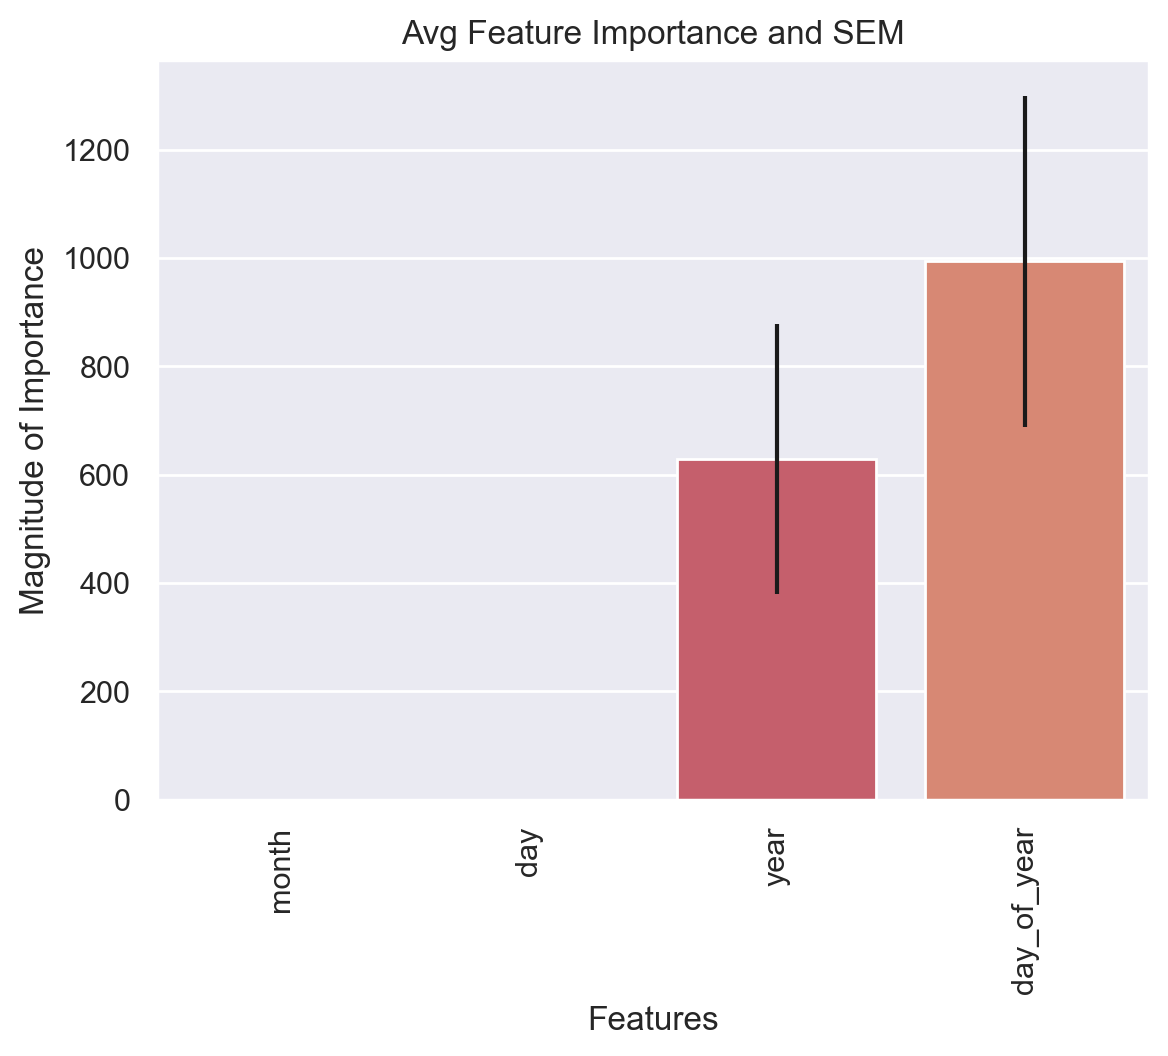

In [26]:
oof_preds_monthly = summarize_models(oof_preds, scores, fi, arima_rmse)

I tried fitting with lag features of 1, 2, 3, and 4 years but that made the RMSE worse.

# Comparison with ARIMA

The scores are comparable for ARIMA and LGBM, but I might be able to improve the LGBM model by adding more features and hyperparameter tuning.

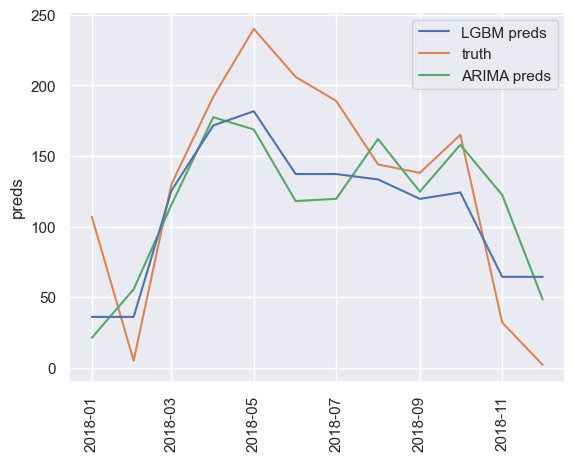

In [27]:
sns.lineplot(x=monthly.index[oof_preds_monthly.query('fold == 0')['data_ind']], y=oof_preds_monthly.query('fold == 0')['preds'], label='LGBM preds', zorder=2)
sns.lineplot(x=monthly.index[oof_preds_monthly.query('fold == 0')['data_ind']], y=oof_preds_monthly.query('fold == 0')['y_true'], label='truth', zorder=1)
sns.lineplot(x=monthly.index[oof_preds_monthly.query('fold == 0')['data_ind']], y=oof_preds_monthly.query('fold == 0')['arima_preds'], label='ARIMA preds', zorder=1)
plt.xticks(rotation=90);

# Final Model

Next I will train a final model on all available data for use in the dashboard.

In [28]:
reg = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=800, max_depth=3)
reg.fit(monthly.drop(['total_rain_mm'], axis=1), monthly.total_rain_mm)

LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=800)

In [29]:
SAVE_MODEL = True
MODEL_PATH = 'data/time_series_model_lgbm.joblib'

if SAVE_MODEL is True:
    dump(reg, MODEL_PATH)